In [1]:
import numpy as np
import math
import random
import cv2
  
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from operator import itemgetter

In [2]:
f = open("waypoints.txt")    # open file in current directory

waypoint = f.readlines()

new_strings = []

for string in waypoint:
    new_string = string.replace("\n", "")
    new_strings.append(new_string)

splitList = [l.split(',') for l in ','.join(new_strings).split('---')]


In [3]:
ids = []
allElems = []

for block in splitList:
    blockElems = []
    block = list(filter(None, block))
    ide = int(block[0])
    
    for elem in block[1:]:
        coord = elem.split(' ')
        intCoord = [float(i) for i in coord]
        blockElems.append(intCoord)
    
    if(ide != 25 and ide != 13 and ide != 7 and ide != 8):
        blockElems.reverse()
        #print(ide)
        
    allElems.append(blockElems)

order = [7,6,10,9,3,1,2,8,5,11,4,0]
ordered_waypoints = [x for _,x in sorted(zip(order,allElems))]

In [4]:
# Convert to vectors
originalAngles = [3.14159,0.523597,0.523597,-0.785403,3.14159,3.14159,3.14159,3.14159,3.14159,3.14159,3.14159,3.14159]

vectors = []

for road in ordered_waypoints:
    vector = []
    for i in range(1,len(road)):
        vectorComp = []
        zip_object = zip(road[i], road[i-1])
        for list1_i, list2_i in zip_object:
            vectorComp.append(list1_i-list2_i)
        vector.append(vectorComp)
    vectors.append(vector)
    
rotatedVectors = []
for idx, road in enumerate(vectors):
    for vector in road:
        vectorComp = []
        vectorComp.append(math.cos(originalAngles[idx])*vector[0]-math.sin(originalAngles[idx])*vector[1])
        vectorComp.append(math.sin(originalAngles[idx])*vector[0]+math.cos(originalAngles[idx])*vector[1])
        vectorComp.append(vector[2])
        rotatedVectors.append(vectorComp)

globalWaypoints = [[0,0,0]]
globalWaypoints = globalWaypoints + list(np.cumsum(rotatedVectors, axis = 0))
globalWaypoints = [list(x) for x in globalWaypoints]

revGlobalWaypoints = list(reversed(globalWaypoints))
revRotatedVectors = [ [-x[0],-x[1],-x[2]] for x in list(reversed(rotatedVectors))]

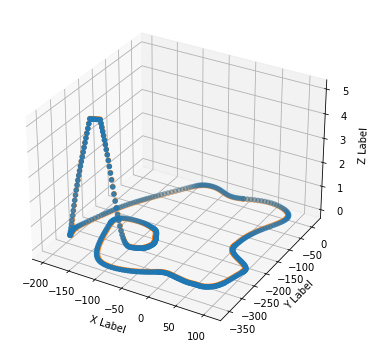

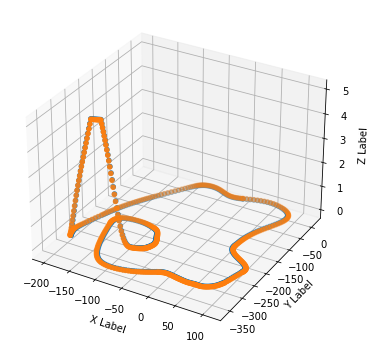

In [5]:
# Compute mean vectors at each waypoint
meanVectors=[]
for idx, vector in enumerate(rotatedVectors[1:],1):
    vectorComp = []
    zip_object = zip(rotatedVectors[idx], rotatedVectors[idx-1])
    for list1_i, list2_i in zip_object:
        vectorComp.append((list1_i+list2_i)/2)
    meanVectors.append(vectorComp)

revMeanVectors=[]
for idx, vector in enumerate(revRotatedVectors[1:],1):
    vectorComp = []
    zip_object = zip(revRotatedVectors[idx], revRotatedVectors[idx-1])
    for list1_i, list2_i in zip_object:
        vectorComp.append((list1_i+list2_i)/2)
    revMeanVectors.append(vectorComp)

# Compute normal vectors to the right
normalVectors = list(map((lambda x: [x[1],-x[0], x[2]]), meanVectors))
revNormalVectors = list(map((lambda x: [x[1],-x[0], x[2]]), revMeanVectors))

# Compute normalized normal vectors
unitNormalVectors = list(map((lambda x: list(x[0:2]/np.linalg.norm(x[0:2])) + [x[2]]), normalVectors))
revUnitNormalVectors = list(map((lambda x: list(x[0:2]/np.linalg.norm(x[0:2])) + [x[2]]), revNormalVectors))

# Compute waypoints with offset
OFFSET = 1.6
revOFFSET = 1.6
zipObject = list(zip(unitNormalVectors, globalWaypoints[1:-1]))
movedWaypoints = list(map((lambda x: [OFFSET*x[0][0] + x[1][0], OFFSET*x[0][1] + x[1][1], x[1][2]]), zipObject))
revZipObject = list(zip(revUnitNormalVectors, revGlobalWaypoints[1:-1]))
revMovedWaypoints = list(map((lambda x: [revOFFSET*x[0][0] + x[1][0], revOFFSET*x[0][1] + x[1][1], x[1][2]]), revZipObject))

# First and last waypoints 
meanFLVec = [(rotatedVectors[0][0] + rotatedVectors[-1][0])/2, (rotatedVectors[0][1] + rotatedVectors[-1][1])/2]
normalFLVec = [meanFLVec[1], -meanFLVec[0]]
unitNormalFLVec = [normalFLVec[0]/np.linalg.norm(normalFLVec), normalFLVec[1]/np.linalg.norm(normalFLVec)]
movedWaypoints = [[globalWaypoints[0][0]+OFFSET*unitNormalFLVec[0],globalWaypoints[0][1]+OFFSET*unitNormalFLVec[1],0.]]  + movedWaypoints + [[globalWaypoints[-1][0]+OFFSET*unitNormalFLVec[0],globalWaypoints[-1][1]+OFFSET*unitNormalFLVec[1],0.]] 
revMovedWaypoints = [[revGlobalWaypoints[0][0]+revOFFSET*-unitNormalFLVec[0],revGlobalWaypoints[0][1]+revOFFSET*-unitNormalFLVec[1],0.]]  + revMovedWaypoints + [[revGlobalWaypoints[-1][0]+revOFFSET*-unitNormalFLVec[0],revGlobalWaypoints[-1][1]+revOFFSET*-unitNormalFLVec[1],0.]]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = [x[0] for x in globalWaypoints]
ys = [x[1] for x in globalWaypoints]
zs = [x[2] for x in globalWaypoints]
xs1 = [x[0] for x in movedWaypoints]
ys1 = [x[1] for x in movedWaypoints]
zs1 = [x[2] for x in movedWaypoints]

ax.scatter(xs,ys,zs)
ax.scatter(xs1,ys1,zs1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
fig.subplots_adjust(top=1.1, bottom=-.1)
plt.show()
fig.savefig("foo.pdf", bbox_inches='tight')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = [x[0] for x in revGlobalWaypoints]
ys = [x[1] for x in revGlobalWaypoints]
zs = [x[2] for x in revGlobalWaypoints]
xs1 = [x[0] for x in revMovedWaypoints]
ys1 = [x[1] for x in revMovedWaypoints]
zs1 = [x[2] for x in revMovedWaypoints]

ax.scatter(xs,ys,zs)
ax.scatter(xs1,ys1,zs1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
fig.subplots_adjust(top=1.1, bottom=-.1)
plt.show()

In [6]:
# Compute vectors of moved waypoints for angle and distance values
laneVectors = []
for idx, wp in enumerate(movedWaypoints[1:],1):
    vectorComp = []
    zip_object = zip(movedWaypoints[idx], movedWaypoints[idx-1])
    for list1_i, list2_i in zip_object:
        vectorComp.append(list1_i-list2_i)
    laneVectors.append(vectorComp)
    
revLaneVectors = []
for idx, wp in enumerate(revMovedWaypoints[1:],1):
    vectorComp = []
    zip_object = zip(revMovedWaypoints[idx], revMovedWaypoints[idx-1])
    for list1_i, list2_i in zip_object:
        vectorComp.append(list1_i-list2_i)
    revLaneVectors.append(vectorComp)

# compute heading and distance between waypoints
normAngles = list(map((lambda x: math.atan2(x[1],x[0])), laneVectors))
revNormAngles = list(map((lambda x: math.atan2(x[1],x[0])), revLaneVectors))
distances = list(map((lambda x: math.sqrt(x[0]**2 + x[1]**2 + x[2]**2)), laneVectors))
revDistances = list(map((lambda x: math.sqrt(x[0]**2 + x[1]**2 + x[2]**2)), revLaneVectors))

# Correction for weird heading in descendant bridge segment
for i in range(146,157):
    revNormAngles[i]+=0.06

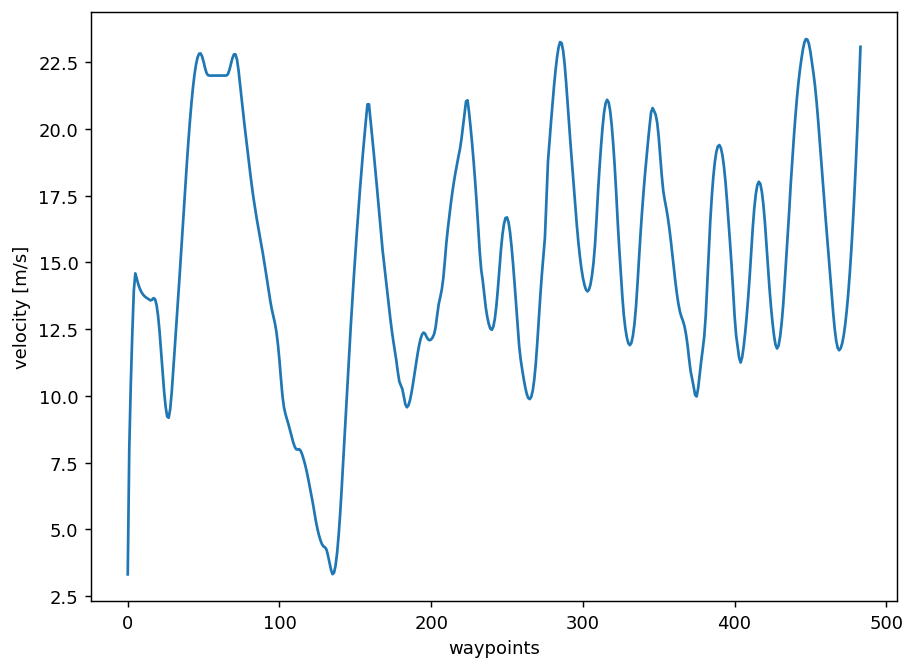

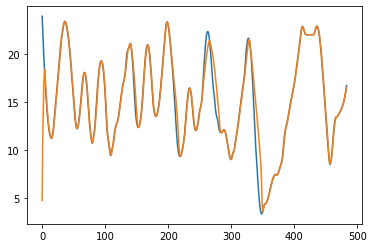

In [13]:
# Velocity part 
def compute_velocity(x):
    if(x > 0.0001):
        return min(math.sqrt(9.81/3/(x**(1))), 22.) # maximum 80kmh
    else:
        return 22;

def compute_velocities(wps):
    velocities = []
    x = [wp[0] for wp in wps]
    y = [wp[1] for wp in wps]
    z = [wp[2] for wp in wps]

    dx = np.gradient(x)
    dy = np.gradient(y)

    d2x = np.gradient(dx)
    d2y = np.gradient(dy)

    curvature = np.abs(dx * d2y - d2x * dy) / (dx * dx + dy * dy)**1.5
    velocities = [compute_velocity(item) for item in curvature]
    velocities_z = list(zip(velocities, z))

    velocities = list(map((lambda x: x[0]/4 if x[1]>3 else x[0]), velocities_z))
    return velocities

def compute_real_vel(velCommands, segDist):
    realVel = []
    realVel.append(0.0)
    zip_obj = zip(velCommands, segDist)
    for vel, dist in zip_obj:
        if(vel > realVel[-1]):
            a = 6.944
        else:
            a = -6.944
        if (2*a*dist+realVel[-1]**2 <0):
            newVel = 0
        else:
            newVel = math.sqrt(2*a*dist+realVel[-1]**2)
        if(a >0 and newVel > vel):
            newVel = vel
        elif (a<0 and newVel <vel):
            newVel = vel
            
        realVel.append(newVel)
    return realVel

# Compute rough velocity in function of curvature of road
velocities = compute_velocities(movedWaypoints)
revVelocities = compute_velocities(revMovedWaypoints)

# Compute mean velocity for each segment
velAvgs = [(velocities[n]+velocities[n-1])/2 for n in range(1,len(velocities))]
revVelAvgs = [(revVelocities[n]+revVelocities[n-1])/2 for n in range(1,len(revVelocities))]

# Smooth the speed curve
velAvgs = savgol_filter(velAvgs, 31, 3) # window size 31, polynomial order 3
revVelAvgs = savgol_filter(revVelAvgs, 31, 3) # window size 31, polynomial order 3

# Compute real speeds at waypoints from commands and distance (taking acceleration in account)
velReal = compute_real_vel(velAvgs, distances)
revVelReal = compute_real_vel(revVelAvgs, revDistances)

# Compute real speed during a segment with an average
velRealAvgs = [(velReal[n]+velReal[n-1])/2 for n in range(1,len(velReal))]
revVelRealAvgs = [(revVelReal[n]+revVelReal[n-1])/2 for n in range(1,len(revVelReal))]

#plt.plot(revVelAvgs)
plt.figure()
plt.xlabel("waypoints")
plt.ylabel("velocity [m/s]")
plt.plot(revVelRealAvgs)
plt.figure()
plt.plot(velAvgs)
plt.plot(velRealAvgs)
#plt.hist(revVelAvgs)

In [9]:
# Compute time in each segment using distances and real velocity
times = [i / j * 1000 for i, j in zip(distances, velRealAvgs)]
revTimes = [i / j * 1000 for i, j in zip(revDistances, revVelRealAvgs)]

accTimes = np.cumsum(times)
revAccTimes = np.cumsum(revTimes)

In [10]:
# Write trajectory planning values to text files
np.savetxt('CW-files/timestamps.txt', accTimes)
np.savetxt('CW-files/velstamps.txt', velAvgs)
np.savetxt('CW-files/anglestamps.txt', normAngles)

np.savetxt('CC-files/timestamps.txt', revAccTimes)
np.savetxt('CC-files/velstamps.txt', revVelAvgs)
np.savetxt('CC-files/anglestamps.txt', revNormAngles)